In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from ipywidgets import interact
import pymongo
import h5py

In [23]:
def load_stacks(beamline : str , sample_name : str , scan_type : str):
    client = pymongo.MongoClient('mongodb://localhost/')
    db = client['in_situ_fluo']
    stack_coll = db['stacks']
    query = {}
    
    query['beamline'] = beamline
    
    query['sample_name'] = sample_name
    
    query['scan_type'] = scan_type
    stack_doc = stack_coll.find_one(query)
    element_names = ['Al_Ka', 'Mn_Ka', 'Cr_Ka']
    images = {}
    print(stack_doc['file_path'])
    with h5py.File(stack_doc['file_path'], 'r') as f:
        stack_group = f[f'/registered/line_intensities']
        
        for element in element_names:
            images[element] = stack_group[element][()]

        unix_time = f['/unregistered/unix_time'][()]
        mean_scan_times = np.nanmean(unix_time, axis=(1,2))
        hours = mean_scan_times/(60*60)
        hours = hours-hours[0]
    return images, hours

    

In [40]:
images, hours = load_stacks('P06', '08_alloy_C_lamella_A_roco', 'jmesh ROI2')


hours = np.arange(0,len(hours))

/data/lazari/data/chalmers_al_am/Al_AM_P06/process/08_alloy_C_lamella_A_roco/stacks/jmesh ROI2.h5


In [41]:

from matplotlib.patches import Rectangle
vmin =0
vmax = 200
col_roi = 40
row_roi = 130
box_width = 5
@interact(im_nr=(0,len(images['Mn_Ka'])-1, 1), element=images.keys(), vmin=(0,5000, 1), vmax=(10,5000,1),row_roi=(0, images['Mn_Ka'][0].shape[0], 1), col_roi=(0,images['Mn_Ka'][0].shape[1], 1))

def plot_im(im_nr, element, vmin , vmax, row_roi, col_roi):
    plt.figure(figsize=(8,8))
    plt.imshow(images[element][im_nr],vmin=vmin, vmax=vmax,cmap='hot', origin='upper')
    
    #plt.imshow(np.log(images[im_nr]), vmin=3,vmax=6.5)
    plt.title(f'{element}. t: {hours[im_nr]} h')
    plt.axis('off')
    ax = plt.gca()
    
    ax.add_patch(Rectangle((col_roi,row_roi), box_width,box_width, fill=False))
    

    
    plt.colorbar()

interactive(children=(IntSlider(value=11, description='im_nr', max=22), Dropdown(description='element', option…

In [67]:
rois = {
    'ROI1' : (42,71),
    'ROI2' : (37, 60),
    'ROI3' : (37, 51),
    'ROI4' : (38, 38),
    'ROI5' : (60, 60),
    'ROI6' : (47, 37)
  
    
}

#'ROI5' : (27, 17),


In [68]:
indexes =list(rois.keys())
indexes.extend([f'{roi}_std' for roi in rois.keys()])
print(indexes)
df = pd.DataFrame(columns=list(images.keys()), index=indexes)



for element in list(df.columns):
    
    
    for roi in rois.keys():
        df[element][roi] = []
        df[element][f'{roi}_std'] = []
        for im in images[element]:
            
            inten = im[rois[roi][0]:rois[roi][0]+box_width, rois[roi][1]:rois[roi][1]+box_width]
            
       
            df[element][roi].append(np.nanmean(inten))
            df[element][f'{roi}_std'].append(np.nanstd(inten))
        df[element][roi] = np.array(df[element][roi])
        df[element][f'{roi}_std'] = np.array(df[element][f'{roi}_std'])
        

['ROI1', 'ROI2', 'ROI3', 'ROI4', 'ROI5', 'ROI6', 'ROI1_std', 'ROI2_std', 'ROI3_std', 'ROI4_std', 'ROI5_std', 'ROI6_std']


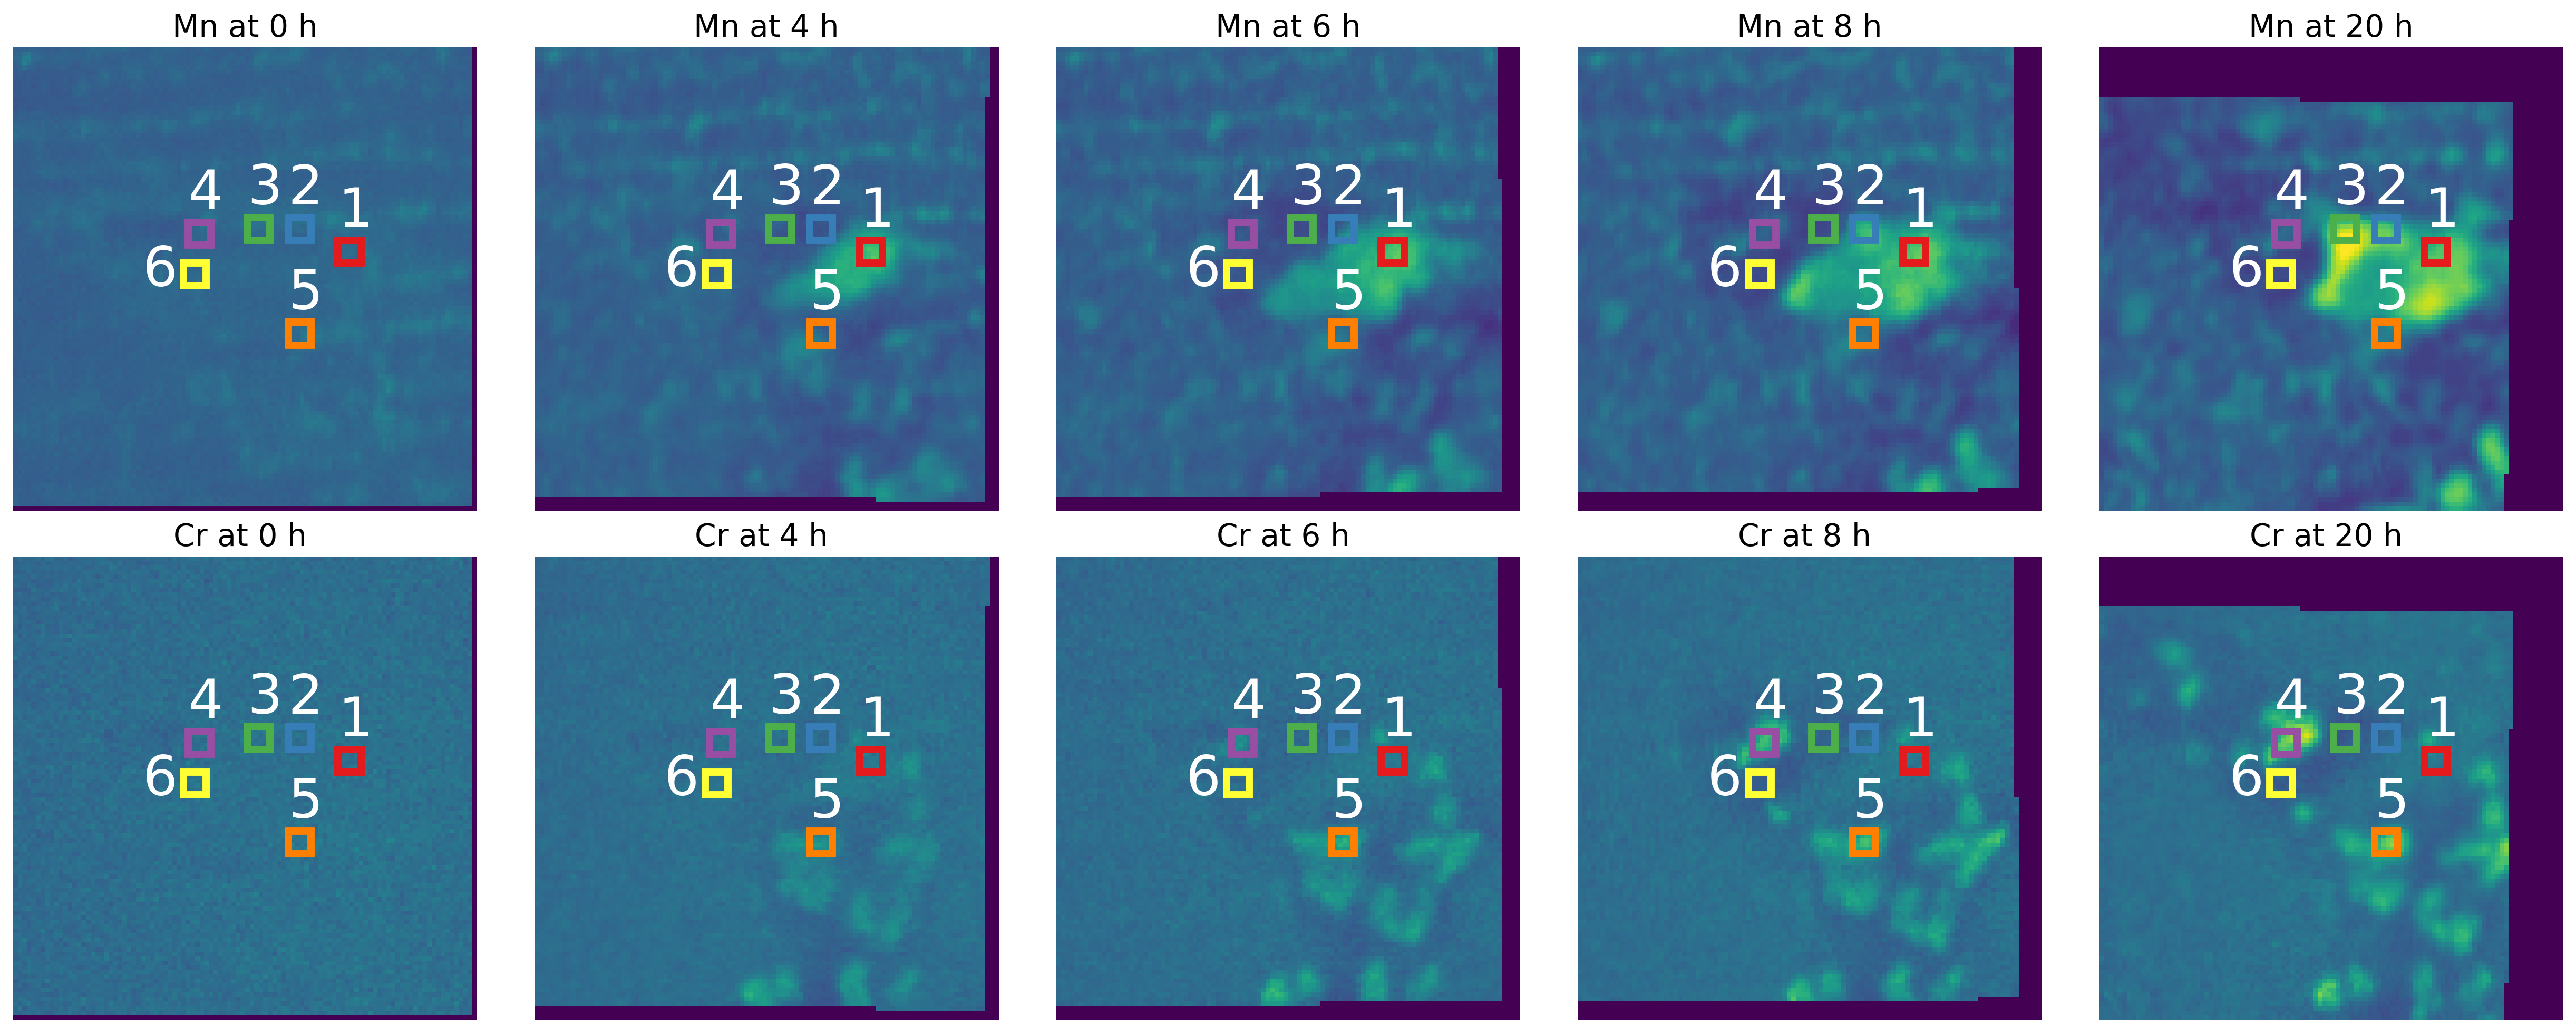

In [77]:
images['total'] = np.zeros(shape=(len(hours),) + images['Mn_Ka'][0].shape ) 
for element in list(images.keys())[0:-1]:
    

    for h in range(0,len(hours)):
        
        images['total'][h] += images[element][h]
    
hours_choice = np.array([0,4, 6,8,20])

fig = plt.figure(figsize=(20,8) , dpi=250)
#fig.suptitle('Raw intensities')
axs = fig.subplots(2,len(hours_choice))
for idx, h in enumerate(hours_choice):
    im_to_show = images['Mn_Ka'][h].copy()
    im_to_show[np.isnan(im_to_show)] = 0

    axs[0][idx].imshow(im_to_show, vmin=0, vmax=2500)
    axs[0][idx].set_title(f'Mn at {hours[h]} h')
    axs[0][idx].axis('off')
    #axs[0][h].imshow(images['Mn_Ka'][h], vmax=240)
    im_to_show = images['Cr_Ka'][h].copy()
    im_to_show[np.isnan(im_to_show)] = 0
    axs[1][idx].imshow(im_to_show,vmin=0, vmax=350, cmap='viridis' )
    axs[1][idx].axis('off')
    axs[1][idx].set_title(f'Cr at {hours[h]} h ')



    for i, roi in enumerate(rois):
        #im_to_show[rois[roi][0]:rois[roi][0]+box_width, rois[roi][1]:rois[roi][1]+box_width] = 50
        #axs[1][idx].imshow(im_to_show, vmin=6, vmax=50)
        row_roi = rois[roi][0]
        col_roi = rois[roi][1]
        axs[0][idx].add_patch(Rectangle((col_roi,row_roi), box_width,box_width, fill=False, color=cmap[i], linewidth=4))
        axs[1][idx].add_patch(Rectangle((col_roi,row_roi), box_width,box_width, fill=False, color=cmap[i], linewidth=4))
        if roi == 'ROI6':
            axs[0][idx].text(col_roi-9, row_roi+5, roi.split('ROI')[-1], size=30, color='white')
            axs[1][idx].text(col_roi-9, row_roi+5, roi.split('ROI')[-1], size=30, color='white')
        else:  
            axs[0][idx].text(col_roi, row_roi-3, roi.split('ROI')[-1], size=30, color='white')
            axs[1][idx].text(col_roi, row_roi-3, roi.split('ROI')[-1], size=30, color='white')
plt.tight_layout()
folder_save_path= '../in-situ_anneal_AM_AlMnCrZr/out/figures/'
if not os.path.exists(folder_save_path):
    os.makedirs(folder_save_path)
plt.savefig(os.path.join(folder_save_path, 'Mn_Cr_intensity_maps.png'), transparent=False, bbox_inches='tight', )

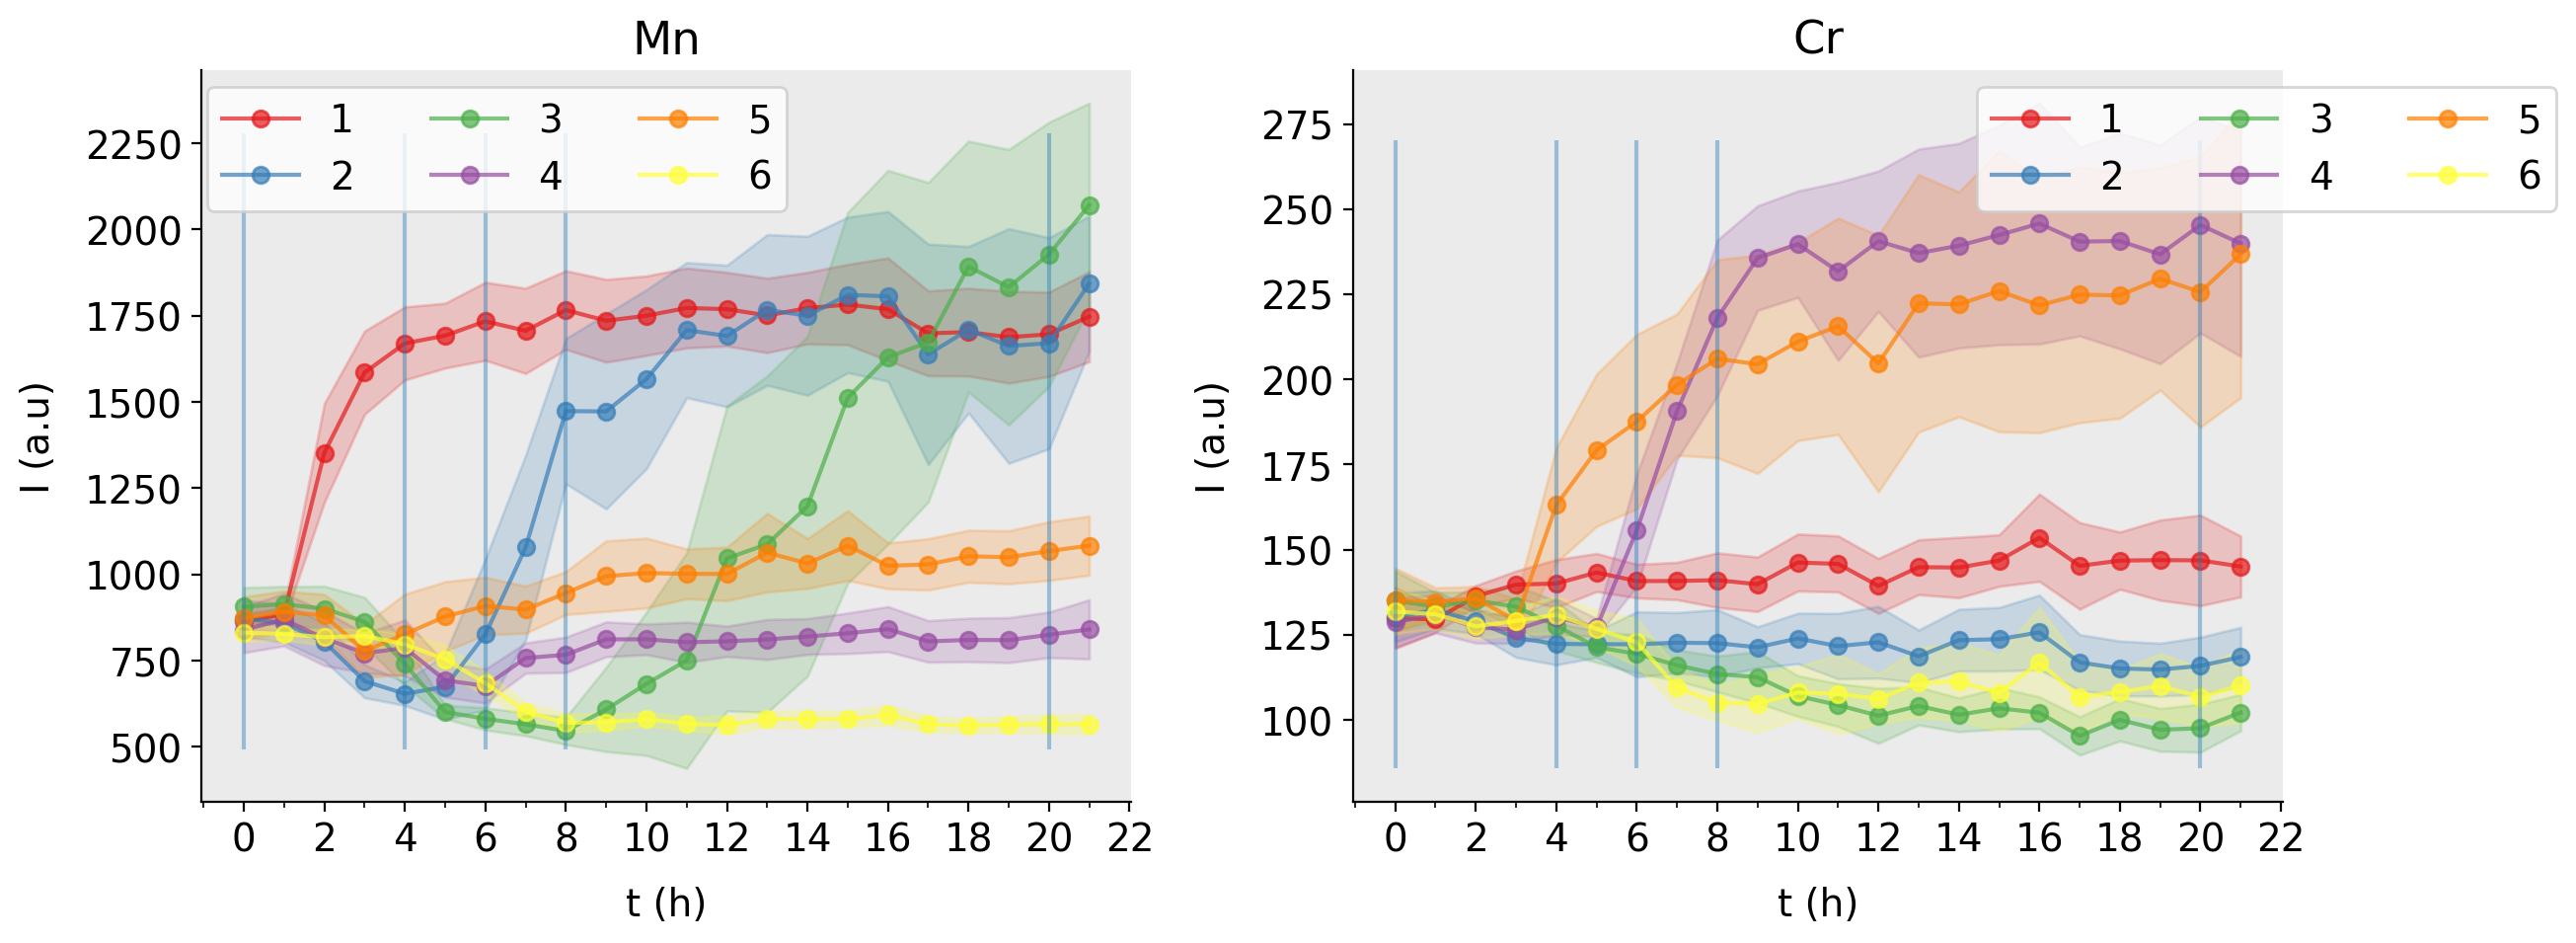

In [76]:
from matplotlib import cm
import matplotlib as mpl
element_choice =['Cr_Ka', 'Mn_Ka']  
plt.rcParams['font.size'] = 14

cmap = (cm.Set1.colors)
fig = plt.figure(figsize=(12,5), dpi=200)
axs = fig.subplots(1,2)
axs = np.ravel(axs)
for idx1, element in enumerate(list(df.columns)[1:3]):
    ymin = np.inf
    ymax = 0
    for idx2, roi in enumerate(rois):
        y = df[element][roi][:-1]
        std = df[element][f'{roi}_std'][:-1]
        if np.nanmax(y) > ymax:
            ymax = np.nanmax(y)
        if np.nanmin(y) < ymin:
            ymin = np.nanmin(y)

        #axs[idx1].plot(hours[:-1],df[element][roi][:-1]/df[element][roi][0], '-o', label=roi.split('ROI')[-1], color=cmap[idx2])
        axs[idx1].plot(hours[:-1],y, '-o', label=roi.split('ROI')[-1], color=cmap[idx2], alpha=0.7)
        axs[idx1].fill_between(hours[:-1], y-std, y+std,color=cmap[idx2], alpha=0.2 )
    axs[idx1].set_title(element[0:2])
    axs[idx1].spines['right'].set_visible(False)
    axs[idx1].spines['top'].set_visible(False)
    axs[idx1].set_xlabel('t (h)', labelpad=10)
    axs[idx1].set_ylabel('I (a.u)', labelpad=10)
    axs[idx1].xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    axs[idx1].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    #axs[idx1].set_ylabel('Relative intensity (a.u.)')
    axs[idx1].set_facecolor((0.92, 0.92, 0.92))
    
    #ylims = [0.5, 2.5]
    ylims = [ymin-ymin/10, ymax+ymax/10]
    #axs[idx1].set_ylim(ylims)
    axs[idx1].vlines(hours_choice, ylims[0], ylims[1], alpha=0.4)

plt.tight_layout()
axs[0].legend(bbox_to_anchor=(0.65,0.78), ncol=int(len(rois)/2), frameon=True)
axs[1].legend(bbox_to_anchor=(0.65,0.78), ncol=int(len(rois)/2), frameon=True)
folder_save_path= '../in-situ_anneal_AM_AlMnCrZr/out/figures/'
if not os.path.exists(folder_save_path):
    os.makedirs(folder_save_path)
plt.savefig(os.path.join(folder_save_path, 'roi_intensities.png'), transparent=False, bbox_inches='tight', )

Fractions